# Sensor fotônico
#### Bovine Brucellosis (Bactéria)

Análise das imagens de um sensor fotônico (guia de onda) para a detecção de uma bactéria através dos pontos de espalhamento gerados no processo de decantação

***
#### **Mestranda**
Bianca Tieppo
***
#### Orientação
Profa. Dra. Lúcia Akemi Miyazato Saito (UPM)
<br>Profa. Dra. Daniella Lopez Vale (UFRJ)
***

#### Análise do Dataframe composto pelos dados obtidos a partir das imagens

In [1]:
# Importar as bibliotecas padrões
%matplotlib inline 

import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sn
import shutil

# Bibliotecas RNA
from graphviz import Digraph
from scipy.stats import pointbiserialr
from sklearn.metrics import (accuracy_score, 
                             brier_score_loss,
                             classification_report, 
                             confusion_matrix, 
                             f1_score,
                             log_loss,
                             mean_squared_error, 
                             precision_score,
                             r2_score, 
                             recall_score, 
                             roc_auc_score)
from sklearn.model_selection import cross_val_score, 
                                    GridSearchCV, 
                                    KFold, 
                                    learning_curve, 
                                    train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Bibliotecas para plots interativos
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objs as go

In [2]:
def current_path(): 
    print("Current working directory") 
    print(os.getcwd()) 
    print() 
  
current_path() 
os.chdir(r'C:\Users\Bruno\Processamento\BBD_Dataframe_vs7') 
current_path() 

Current working directory
C:\Users\Bruno\Processamento

Current working directory
C:\Users\Bruno\Processamento\BBD_Dataframe_vs7



In [3]:
df = pd.read_excel("DataCV.xlsx")

In [4]:
df.head()

,Chip,Name_of_sample,Datetime,ValueH,ValueS,ValueV,Total_area,Number_of_spots_cv2,Number_of_spots_LoG,Number_of_spots_DoG,Number_of_spots_DoH,Target
0,01-03-23_positive1,100min.jpg,2023-03-01 15:30:50,133.225104,240.931406,143.409167,434.0,8,139,103,6,Positive
1,01-03-23_positive1,105min.jpg,2023-03-01 15:35:20,134.332344,238.821302,146.889948,765.5,11,197,146,8,Positive
2,01-03-23_positive1,10min.jpg,2023-03-01 14:00:14,135.249566,246.915191,77.204861,0.0,0,0,0,0,Positive
3,01-03-23_positive1,110min.jpg,2023-03-01 15:39:46,127.686903,244.463487,141.553602,221.5,6,92,56,1,Positive
4,01-03-23_positive1,120min.jpg,2023-03-01 15:49:44,135.096705,240.158403,144.349559,497.0,8,185,110,11,Positive


In [5]:
df.shape

(718, 12)

## Análise da correlação das variáveis

In [6]:
df_chip = df.copy()

In [7]:
# Cria as colunas de data e tempo
df_chip['Date_c'] = df_chip['Datetime'].dt.date
df_chip['Time_c'] = df_chip['Datetime'].dt.time

In [8]:
df_chip = df_chip.sort_values(['Date_c', 'Time_c'], ascending=[True, True])

In [9]:
group = df_chip.groupby(['Date_c', 'Chip'])

# Criação de uma coluna com o valor do arquivo correspondente
df_chip['Minute_start'] = df_chip['Name_of_sample'].str.extract(r'(\d+)').astype(float).fillna(0).astype(int)

# Criação de uma coluna com a diferença de tempo em minutos desde o primeiro registro
df_chip['Minute'] = df_chip.groupby(['Date_c', 'Chip']).apply(lambda x: (x['Datetime'] - x['Datetime'].iloc[0]).dt.total_seconds() // 60).reset_index(level=[0,1], drop=True)

# Ajuste da primeira linha de cada dia
df_chip['Minute'] = df_chip.groupby(['Date_c', 'Chip']).apply(lambda x: x['Minute'] if x.name[0] != 0 else x['Minute_Start']).reset_index(level=[0,1], drop=True)

In [10]:
df_chip.head()

,Chip,Name_of_sample,Datetime,ValueH,ValueS,ValueV,Total_area,Number_of_spots_cv2,Number_of_spots_LoG,Number_of_spots_DoG,Number_of_spots_DoH,Target,Date_c,Time_c,Minute_start,Minute
17,01-03-23_positive1,6min.jpg,2023-03-01 13:56:20,129.171875,245.945849,77.367111,0.0,0,0,0,0,Positive,2023-03-01,13:56:20,6,0.0
2,01-03-23_positive1,10min.jpg,2023-03-01 14:00:14,135.249566,246.915191,77.204861,0.0,0,0,0,0,Positive,2023-03-01,14:00:14,10,3.0
7,01-03-23_positive1,18min.jpg,2023-03-01 14:08:40,134.105655,247.956194,90.288039,0.0,0,0,0,0,Positive,2023-03-01,14:08:40,18,12.0
8,01-03-23_positive1,25min.jpg,2023-03-01 14:15:02,129.186734,247.872472,89.540058,0.0,0,0,0,0,Positive,2023-03-01,14:15:02,25,18.0
9,01-03-23_positive1,30min.jpg,2023-03-01 14:20:04,120.984681,246.438879,81.754596,0.0,0,0,0,0,Positive,2023-03-01,14:20:04,30,23.0


In [11]:
# Agrupando as amostras
grouped = df_chip.groupby('Chip')

min_initial_value = grouped['Minute_start'].min()

# Somando os te
df_chip['Total_Time'] = df_chip['Minute'] + grouped['Minute_start'].transform(lambda x: min_initial_value[x.name])

In [12]:
# Agrupando as amostras por dia e em seguida por amostra
#group = df_chip.groupby(['Date_c', 'Chip'])

# Subtraindo o primeiro horário registrado de cada dia de cada amostra
#df_chip['Time_s'] = group['Datetime'].transform(lambda x: (x - x.iloc[0]).dt.total_seconds() // 60)

# Ajustando a primeira linha de cada dia para 0
#df_chip['Time_s'] = df_chip.groupby(['Date_c', 'Chip'], group_keys=False)['Time_s'].apply(lambda x: x - x.iloc[0] if len(x) > 1 else 0)

In [13]:
# Seleciona as três últimas colunas
last_cols = df_chip.iloc[:, [12, 13, 16]]

# Remove as colunas 
df_chip = df_chip.drop(['Date_c', 'Time_c', 'Minute_start', 'Minute', 'Total_Time'], axis=1)

# Insere as colunas nas posições escolhidas
df_chip.insert(3, 'Date', last_cols.iloc[:, 0])
df_chip.insert(4, 'Time', last_cols.iloc[:, 1])
df_chip.insert(5, 'Time_Sample', last_cols.iloc[:, 2])

In [14]:
df_chip = df_chip.reset_index(drop=True)

In [15]:
df_chip

,Chip,Name_of_sample,Datetime,Date,Time,Time_Sample,ValueH,ValueS,ValueV,Total_area,Number_of_spots_cv2,Number_of_spots_LoG,Number_of_spots_DoG,Number_of_spots_DoH,Target
0,01-03-23_positive1,6min.jpg,2023-03-01 13:56:20,2023-03-01,13:56:20,6.0,129.171875,245.945849,77.367111,0.0,0,0,0,0,Positive
1,01-03-23_positive1,10min.jpg,2023-03-01 14:00:14,2023-03-01,14:00:14,9.0,135.249566,246.915191,77.204861,0.0,0,0,0,0,Positive
2,01-03-23_positive1,18min.jpg,2023-03-01 14:08:40,2023-03-01,14:08:40,18.0,134.105655,247.956194,90.288039,0.0,0,0,0,0,Positive
3,01-03-23_positive1,25min.jpg,2023-03-01 14:15:02,2023-03-01,14:15:02,24.0,129.186734,247.872472,89.540058,0.0,0,0,0,0,Positive
4,01-03-23_positive1,30min.jpg,2023-03-01 14:20:04,2023-03-01,14:20:04,29.0,120.984681,246.438879,81.754596,0.0,0,0,0,0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,04-07-23_negative2,109min.jpg,2023-07-04 17:18:22,2023-07-04,17:18:22,111.0,9.635163,218.942298,16.170706,0.0,0,0,0,0,Negative
714,04-07-23_negative2,112min.jpg,2023-07-04 17:21:28,2023-07-04,17:21:28,115.0,10.991146,217.809718,17.129386,0.0,0,0,0,0,Negative
715,04-07-23_negative2,115min.jpg,2023-07-04 17:24:06,2023-07-04,17:24:06,117.0,8.784060,226.941886,49.725809,0.0,0,0,0,0,Negative
716,04-07-23_negative2,118min.jpg,2023-07-04 17:27:18,2023-07-04,17:27:18,120.0,12.070964,225.428971,48.702734,0.0,0,0,0,0,Negative


In [16]:
df_chip.to_excel("Data_BBD7.xlsx")

## Análise da correlação das variáveis

### Correlação ponto-bisserial

In [17]:
df_corr = df_chip.copy()

In [18]:
df_corr['Target'] = df_corr['Target'].map({'Positive': 1, 'Negative': 0})

In [19]:
df_corr = df_corr.drop(['Chip', 'Name_of_sample', 'Datetime', 'Date', 'Time'], axis=1)

In [20]:
df_corr.head()

,Time_Sample,ValueH,ValueS,ValueV,Total_area,Number_of_spots_cv2,Number_of_spots_LoG,Number_of_spots_DoG,Number_of_spots_DoH,Target
0,6.0,129.171875,245.945849,77.367111,0.0,0,0,0,0,1
1,9.0,135.249566,246.915191,77.204861,0.0,0,0,0,0,1
2,18.0,134.105655,247.956194,90.288039,0.0,0,0,0,0,1
3,24.0,129.186734,247.872472,89.540058,0.0,0,0,0,0,1
4,29.0,120.984681,246.438879,81.754596,0.0,0,0,0,0,1


In [21]:
corr_list = []

y = df_corr['Target'].astype(float)

df_pbc = pd.DataFrame(columns = ['Coluna', 'PBC'])

for column in df_corr.columns:
    x = df_corr[column]
    pbc = pointbiserialr(list(x), list(y))
    corr_pbc = {'Coluna': [column], 
                'PBC': [pbc[0]]}
    df_new_rows = pd.DataFrame(corr_pbc)
    
    df_pbc = pd.concat([df_pbc.dropna(axis = 1, how = 'all'), df_new_rows])

In [22]:
df_pbc.reset_index(drop = True)

,Coluna,PBC
0,Time_Sample,-0.026740
1,ValueH,0.131458
2,ValueS,0.199808
3,ValueV,0.538352
4,Total_area,0.445255
5,Number_of_spots_cv2,0.451897
6,Number_of_spots_LoG,0.523273
7,Number_of_spots_DoG,0.532654
8,Number_of_spots_DoH,0.399606
9,Target,1.000000


### Correlação de Pearson

In [23]:
correlation = df_chip.corr(numeric_only =  True)

<Axes: >

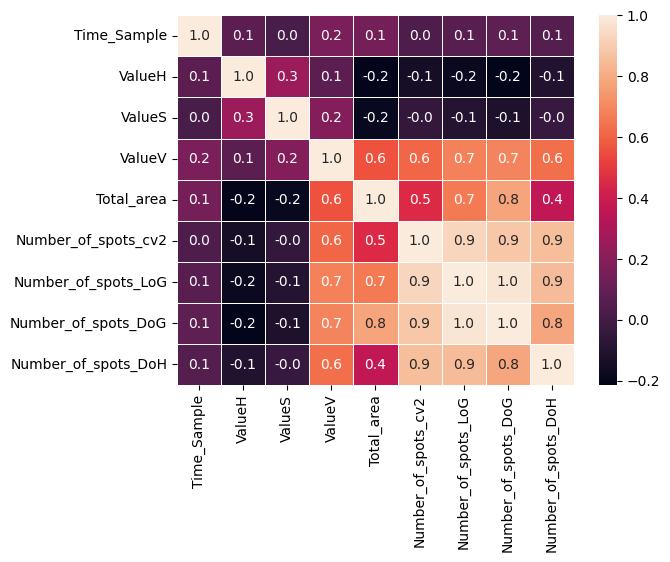

In [24]:
plot_cor = sn.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot_cor

## Testes Estatísticos

### Positivo

In [25]:
df_positive = df_chip.loc[df_chip['Target'] == 'Positive']

In [26]:
df_positive.head()

,Chip,Name_of_sample,Datetime,Date,Time,Time_Sample,ValueH,ValueS,ValueV,Total_area,Number_of_spots_cv2,Number_of_spots_LoG,Number_of_spots_DoG,Number_of_spots_DoH,Target
0,01-03-23_positive1,6min.jpg,2023-03-01 13:56:20,2023-03-01,13:56:20,6.0,129.171875,245.945849,77.367111,0.0,0,0,0,0,Positive
1,01-03-23_positive1,10min.jpg,2023-03-01 14:00:14,2023-03-01,14:00:14,9.0,135.249566,246.915191,77.204861,0.0,0,0,0,0,Positive
2,01-03-23_positive1,18min.jpg,2023-03-01 14:08:40,2023-03-01,14:08:40,18.0,134.105655,247.956194,90.288039,0.0,0,0,0,0,Positive
3,01-03-23_positive1,25min.jpg,2023-03-01 14:15:02,2023-03-01,14:15:02,24.0,129.186734,247.872472,89.540058,0.0,0,0,0,0,Positive
4,01-03-23_positive1,30min.jpg,2023-03-01 14:20:04,2023-03-01,14:20:04,29.0,120.984681,246.438879,81.754596,0.0,0,0,0,0,Positive


In [27]:
summary_grouped = df_positive.groupby('Chip').describe()
summary_grouped

Datetime                                 \
                      count                           mean   
Chip                                                         
01-03-23_positive1       24  2023-03-01 14:58:33.749999872   
02-03-23_positive2       21  2023-03-02 11:05:58.285714432   
02-03-23_positive3       19  2023-03-02 16:48:43.157894912   
03-07-23_positive1       40            2023-07-03 11:16:00   
03-07-23_positive2       39  2023-07-03 14:26:12.974359040   
05-06-23_positive1       41  2023-06-05 16:53:18.829268224   
15-06-23_positive2       37  2023-06-15 15:36:27.999999744   
29-06-23_positive1       39  2023-06-29 12:15:12.615384832   
29-06-23_positive2       37  2023-06-29 17:31:14.432432384   
30-06-23_positive1       38  2023-06-30 11:04:43.315789312   
30-06-23_positive2       38  2023-06-30 15:10:14.578947328   

                                                                     \
                                    min                         25%   
Chip                                                                  
01-03-23_positive1  2023-03-01 13:56:20         2023-03-01 14:29:03   
02-03-23_positive2  2023-03-02 10:18:24         2023-03-02 10:41:04   
02-03-23_positive3  2023-03-02 15:56:56         2023-03-02 16:17:49   
03-07-23_positive1  2023-07-03 10:16:58  2023-07-03 10:46:43.500000   
03-07-23_positive2  2023-07-03 13:25:22         2023-07-03 13:58:02   
05-06-23_positive1  2023-06-05 15:55:08         2023-06-05 16:23:18   
15-06-23_positive2  2023-06-15 14:40:14         2023-06-15 15:07:06   
29-06-23_positive1  2023-06-29 11:18:58         2023-06-29 11:47:02   
29-06-23_positive2  2023-06-29 16:34:06         2023-06-29 17:03:54   
30-06-23_positive1  2023-06-30 10:06:00  2023-06-30 10:37:05.500000   
30-06-23_positive2  2023-06-30 14:12:36  2023-06-30 14:42:45.500000   

                                                                     \
                                    50%                         75%   
Chip                                                                  
01-03-23_positive1  2023-03-01 14:57:55         2023-03-01 15:26:32   
02-03-23_positive2  2023-03-02 11:05:28         2023-03-02 11:32:18   
02-03-23_positive3  2023-03-02 16:40:18         2023-03-02 17:23:04   
03-07-23_positive1  2023-07-03 11:16:03         2023-07-03 11:45:13   
03-07-23_positive2  2023-07-03 14:26:30         2023-07-03 14:55:01   
05-06-23_positive1  2023-06-05 16:53:16         2023-06-05 17:23:18   
15-06-23_positive2  2023-06-15 15:36:58         2023-06-15 16:05:14   
29-06-23_positive1  2023-06-29 12:15:32         2023-06-29 12:42:52   
29-06-23_positive2  2023-06-29 17:30:44         2023-06-29 17:59:42   
30-06-23_positive1  2023-06-30 11:04:53  2023-06-30 11:32:34.500000   
30-06-23_positive2  2023-06-30 15:10:37         2023-06-30 15:38:49   

                                             Time_Sample             ...  \
                                    max  std       count       mean  ...   
Chip                                                                 ...   
01-03-23_positive1  2023-03-01 16:09:08  NaN        24.0  67.666667  ...   
02-03-23_positive2  2023-03-02 11:55:34  NaN        21.0  54.095238  ...   
02-03-23_positive3  2023-03-02 17:49:50  NaN        19.0  57.421053  ...   
03-07-23_positive1  2023-07-03 12:14:42  NaN        40.0  61.525000  ...   
03-07-23_positive2  2023-07-03 15:23:32  NaN        39.0  63.512821  ...   
05-06-23_positive1  2023-06-05 17:53:20  NaN        41.0  59.951220  ...   
15-06-23_positive2  2023-06-15 16:34:06  NaN        37.0  59.621622  ...   
29-06-23_positive1  2023-06-29 13:11:24  NaN        39.0  62.743590  ...   
29-06-23_positive2  2023-06-29 18:26:52  NaN        37.0  62.459459  ...   
30-06-23_positive1  2023-06-30 12:00:30  NaN        38.0  62.315789  ...   
30-06-23_positive2  2023-06-30 16:05:58  NaN        38.0  63.184211  ...   

                   Number_of_spots_DoG             Number_of_spots_DoH  \
                     

In [28]:
# Calcular o máximo, a mínima e a média
maximo_p = df_positive['ValueV'].max()
minima_p = df_positive['ValueV'].min()
media_p = df_positive['ValueV'].mean()

# Imprimir os resultados
print('Máximo:', maximo_p)
print('Mínima:', minima_p)
print('Média:', media_p)

Máximo: 167.7933026175214
Mínima: 19.12026633918618
Média: 86.41102753978788


In [29]:
df_positive.to_excel('DataPositive.xlsx')

In [30]:
df_positive['Chip'].unique()

array(['01-03-23_positive1', '02-03-23_positive2', '02-03-23_positive3',
       '05-06-23_positive1', '15-06-23_positive2', '29-06-23_positive1',
       '29-06-23_positive2', '30-06-23_positive1', '30-06-23_positive2',
       '03-07-23_positive1', '03-07-23_positive2'], dtype=object)

#### Dados brutos

In [92]:
# Plots das variáveis extraídas
def create_app_variavel_positive():
    app = dash.Dash(__name__)

    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    app.layout = html.Div([
        dcc.Dropdown(
            id = 'variavel-positive-dropdown',
            options = [{'label': variavel, 'value': variavel} for variavel in variaveis_positive],
            value = 'ValueH',
            style = {'width': '50%'}
        ),
        dcc.Graph(id = 'grafico_positive'),
    ])

    @app.callback(
        Output('grafico_positive', 'figure'),
        [Input('variavel-positive-dropdown', 'value')]
    )
    def update_graph(selected_variavel_positive):
        fig = px.line(df_positive, x = 'Time_Sample', y = selected_variavel_positive, color = 'Chip', title = f'Variação de {selected_variavel_positive} ao decorrer do tempo',
                      labels = {'Time_Sample': 'Tempo (min)', selected_variavel_positive: 'Valor'})

        fig.update_layout(legend_title='Chip')

        return fig

    return app

app_variavel_positive = create_app_variavel_positive()
app_variavel_positive.run_server(debug = True, port = 8050)

In [119]:
def raw_plots(df_positive):
    current_directory = os.getcwd()

    # Criar o caminho completo para a pasta 'Gráficos'
    graphs_directory = os.path.join(current_directory, 'Gráficos')

    # Verificar se a pasta 'Gráficos' existe e criar se não existir
    if not os.path.exists(graphs_directory):
        os.makedirs(graphs_directory)
        
    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    for variavel in variaveis_positive:
        plt.figure(figsize = (8, 6))

        for chip in df_positive['Chip'].unique():
            # Filtrar o DataFrame por chip e variável
            data = df_positive[df_positive['Chip'] == chip]

            plt.plot(data['Time_Sample'], data[variavel], label = chip)

        plt.xlabel('Tempo (min)')
        plt.ylabel('Valor')
        plt.title(f'Variação de {variavel} ao decorrer do tempo')
        plt.legend(title = 'Chip', loc = 'center left', bbox_to_anchor=(1, 0.5))  # Posiciona a legenda fora do gráfico
        plt.grid(True)

        # Salvar o gráfico como imagem PNG
        plt.savefig(os.path.join(graphs_directory, f'Raw_{variavel}_plot.png'), bbox_inches = 'tight')  # Usado para ajustar o espaço para que a legenda não seja cortada

        # Fechar a figura para liberar memória
        plt.close()

# Chamar a função para gerar e salvar os gráficos
raw_plots(df_positive)

#### Transformada de Fourier

In [77]:
df_fourier_positive = df_positive.copy()
df_fourier_positive = df_fourier_positive.drop(['Name_of_sample', 'Datetime', 'Date', 'Time', 'Target'], axis=1)

In [78]:
pd.set_option('display.max_rows', None)

In [79]:
df_fourier_positive

,Chip,Time_Sample,ValueH,ValueS,ValueV,Total_area,Number_of_spots_cv2,Number_of_spots_LoG,Number_of_spots_DoG,Number_of_spots_DoH
0,01-03-23_positive1,6.0,129.171875,245.945849,77.367111,0.0,0,0,0,0
1,01-03-23_positive1,9.0,135.249566,246.915191,77.204861,0.0,0,0,0,0
2,01-03-23_positive1,18.0,134.105655,247.956194,90.288039,0.0,0,0,0,0
3,01-03-23_positive1,24.0,129.186734,247.872472,89.540058,0.0,0,0,0,0
4,01-03-23_positive1,29.0,120.984681,246.438879,81.754596,0.0,0,0,0,0
5,01-03-23_positive1,34.0,117.804769,247.230225,64.417318,0.0,0,0,0,0
6,01-03-23_positive1,39.0,118.210095,247.204733,82.330653,0.0,0,0,0,0
7,01-03-23_positive1,44.0,127.047641,246.923790,89.124847,0.0,0,0,0,0
8,01-03-23_positive1,50.0,128.187624,245.550285,89.789373,0.0,0,0,0,0
9,01-03-23_positive1,55.0,128.521329,244.253968,80.062376,0.0,0,0,0,0


In [80]:
# Selecionar todas as colunas exceto 'Time_Sample'
columns_fourier = df_fourier_positive.columns.drop(['Chip', 'Time_Sample'])

# Aplicar transformada de Fourier
def apply_fourier(group):
    # Aplicar a transformada de Fourier usando np.fft.fft() nas colunas desejadas
    group[columns_fourier] = group[columns_fourier].apply(lambda col: np.abs(np.fft.fft(col)))
    # Transformar 'Time_Sample' em frequência de Fourier
    group['Time_Sample'] = np.fft.fftfreq(len(group['Time_Sample']))
    return group

# Aplicar a transformada de Fourier por grupo (chip)
df_fourier_positive = df_fourier_positive.groupby('Chip').apply(apply_fourier)

In [93]:
# Plots das variáveis extraídas - Transformada de Fourier
def create_app_fourier_positive():
    app = dash.Dash(__name__)

    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    app.layout = html.Div([
        dcc.Dropdown(
            id = 'fourier-positive-dropdown',
            options = [{'label': variavel, 'value': variavel} for variavel in variaveis_positive],
            value = 'ValueH',
            style = {'width': '50%'}
        ),
        dcc.Graph(id = 'grafico-positive-fourier'),
    ])

    @app.callback(
        Output('grafico-positive-fourier', 'figure'),
        [Input('fourier-positive-dropdown', 'value')]
    )
    def update_graph(selected_variavel_positive):
        fig = px.line(df_fourier_positive, x = 'Time_Sample', y = selected_variavel_positive, color = 'Chip', title = f'Transformada de Fourier de {selected_variavel_positive}',
                      labels = {'Time_Sample': 'Tempo (min)', selected_variavel_positive: 'Valor'})

        fig.update_layout(legend_title='Chip')

        return fig

    return app

app_fourier_positive = create_app_fourier_positive()
app_fourier_positive.run_server(debug = True, port = 8051)

In [114]:
def plots_fourier(df_fourier_positive):
    current_directory = os.getcwd()
    
    # Criar o caminho completo para a pasta 'Gráficos'
    graphs_directory = os.path.join(current_directory, 'Gráficos')

    # Verificar se a pasta 'Gráficos' existe e criar se não existir
    if not os.path.exists(graphs_directory):
        os.makedirs(graphs_directory)
    
    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    for variavel in variaveis_positive:
        plt.figure(figsize = (8, 6))

        for chip in df_fourier_positive['Chip'].unique():
            # Filtrar o DataFrame por chip e variável
            data = df_fourier_positive[df_fourier_positive['Chip'] == chip]

            plt.plot(data['Time_Sample'], data[variavel], label = chip)

        plt.xlabel('Frequência')
        plt.ylabel('Magnitude')
        plt.title(f'Transformada de Fourier de {variavel}')
        plt.legend(title = 'Chip', loc = 'center left', bbox_to_anchor = (1, 0.5))  # Posiciona a legenda fora do gráfico
        plt.grid(True)

        # Salvar o gráfico como imagem PNG
        plt.savefig(os.path.join(graphs_directory, f'Fourier_{variavel}.png'), bbox_inches = 'tight')  # Usado para ajustar o espaço para que a legenda não seja cortada

        # Fechar a figura para liberar memória
        plt.close()

# Chamar a função para gerar e salvar os gráficos
plots_fourier(df_fourier_positive)

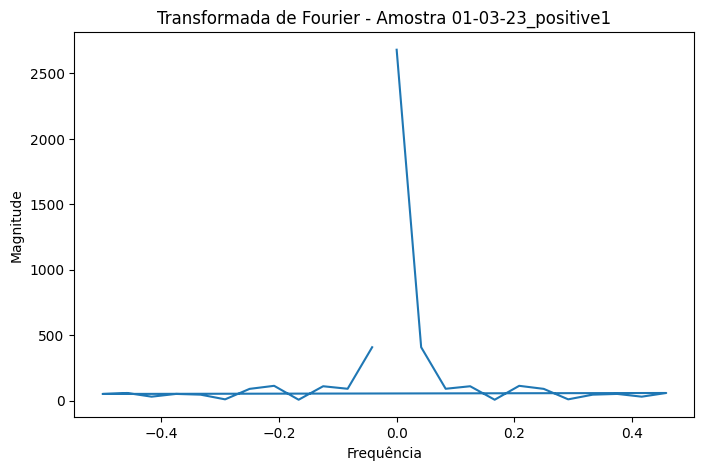

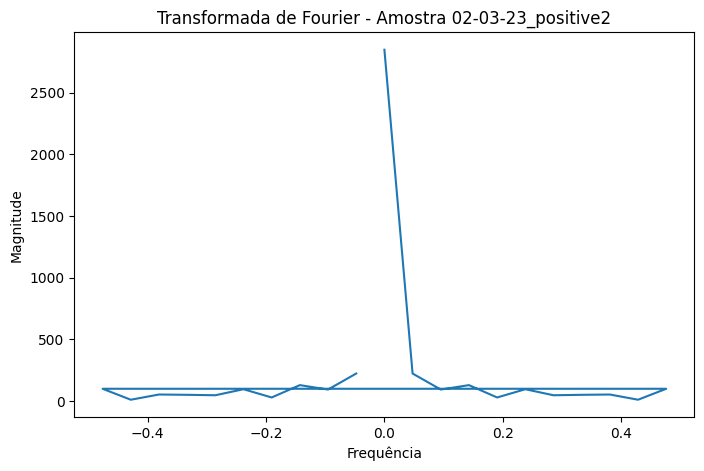

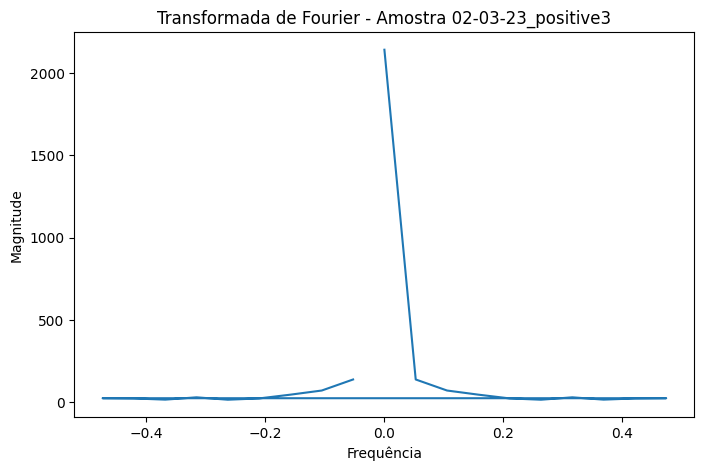

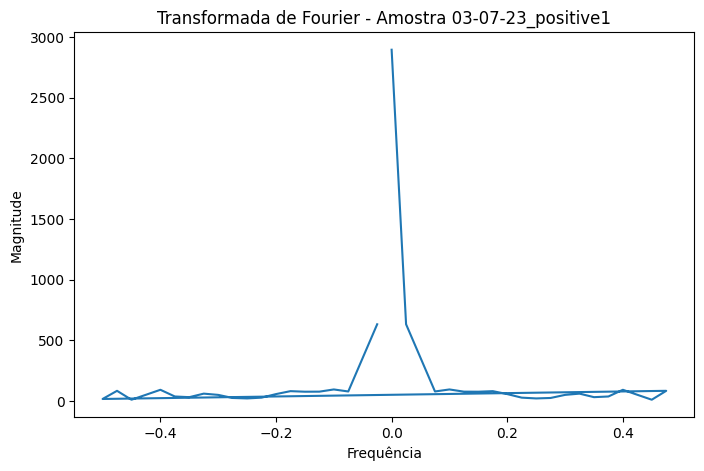

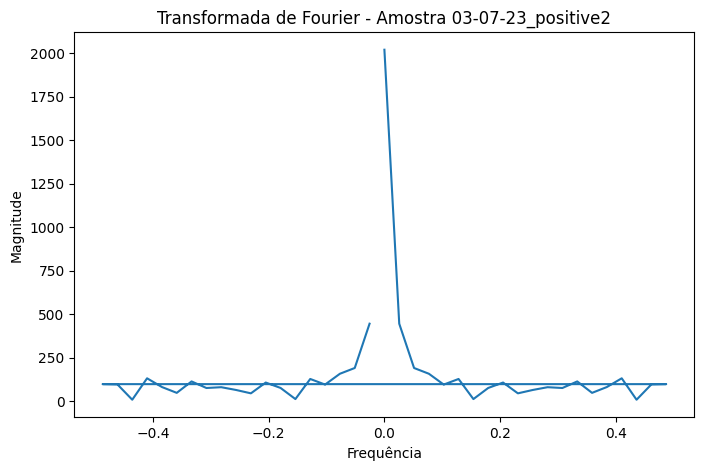

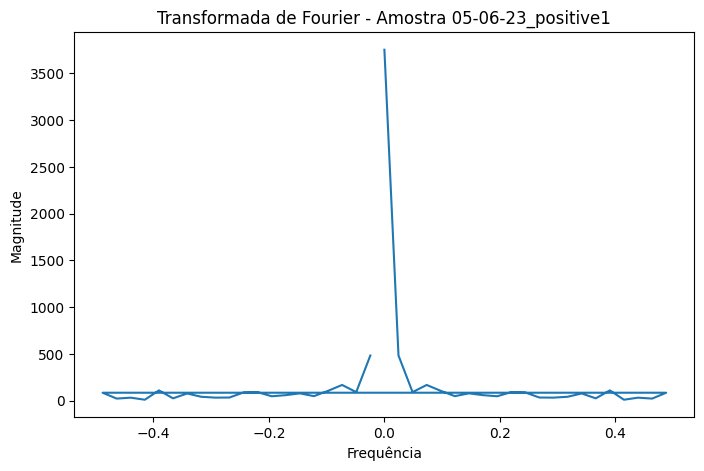

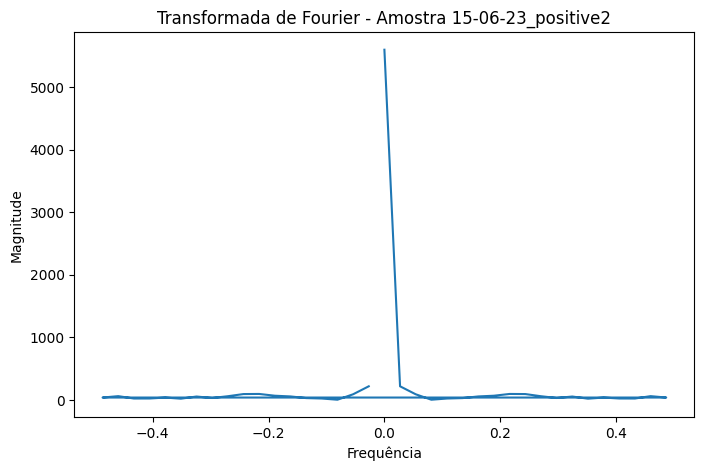

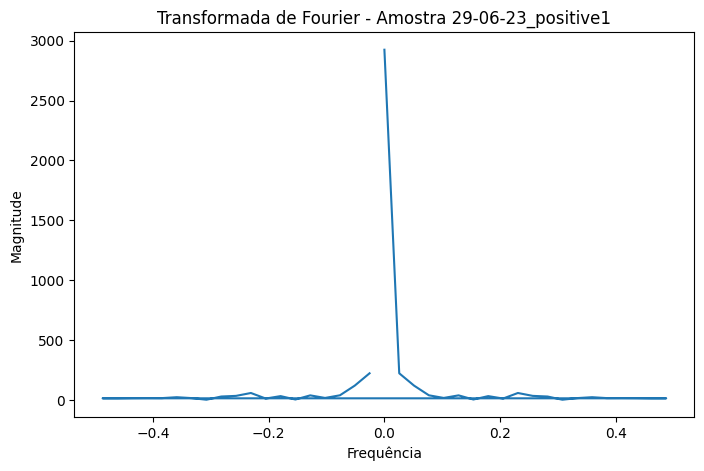

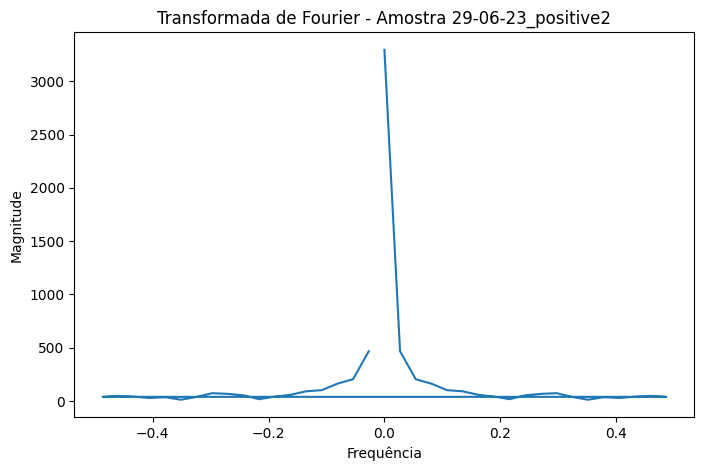

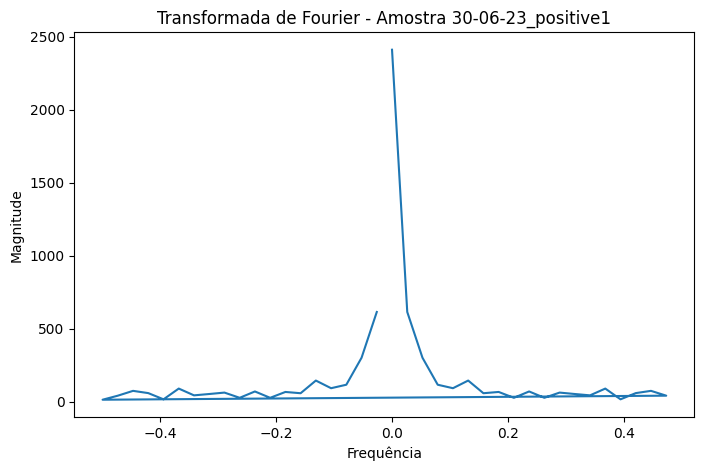

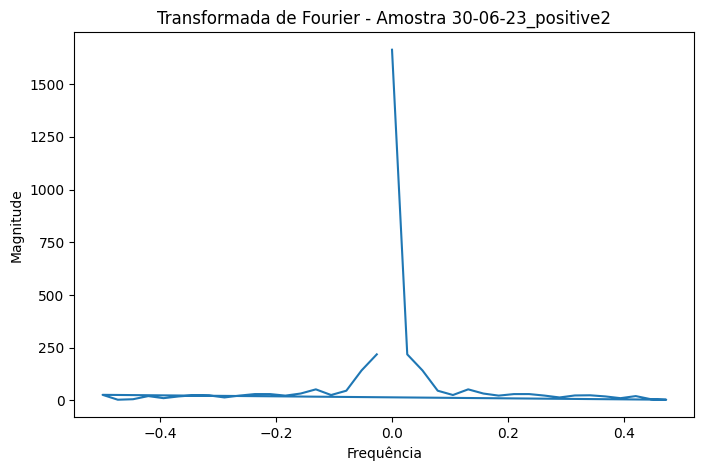

In [96]:
# Função para aplicar a transformada de Fourier
def plot_fourier_transform(sample_data):
    tempo = sample_data['Time_Sample']  # Variável x (tempo)
    brilho = sample_data['ValueV']  # Variável y (brilho)
    
    fourier_transform = np.fft.fft(brilho)  # Aplicar a transformada de Fourier
    freq = np.fft.fftfreq(len(tempo))  # Frequências correspondentes

    plt.figure(figsize = (8, 5))
    plt.plot(freq, np.abs(fourier_transform))  # Plotar a magnitude do espectro
    plt.title('Transformada de Fourier - Amostra {}'.format(sample_data['Chip'].iloc[0]))
    plt.xlabel('Frequência')
    plt.ylabel('Magnitude')
    plt.show()

# Agrupar os dados por amostra (Chip) e aplicar a transformada de Fourier para cada grupo
grupos_positive = df_positive.groupby('Chip')

for nome, grupo in grupos_positive:
    plot_fourier_transform(grupo)

#### Logaritmo Natural

In [82]:
df_ln_positive = df_positive.copy()
df_ln_positive = df_ln_positive.drop(['Name_of_sample', 'Datetime', 'Date', 'Time', 'Target'], axis=1)

In [83]:
# Selecionar todas as colunas exceto 'Time_Sample'
columns_ln_positive = df_ln_positive.columns.drop(['Chip','Time_Sample'])

# Aplicar logaritmo natural
df_ln_positive[columns_ln_positive] = df_ln_positive[columns_ln_positive].apply(lambda col: col.map(lambda x: np.log(x) if x > 0 else x))

In [86]:
# Plots das variáveis extraídas
def create_app_ln_positive():
    app = dash.Dash(__name__)

    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    app.layout = html.Div([
        dcc.Dropdown(
            id = 'ln-positive-dropdown',
            options = [{'label': variavel, 'value': variavel} for variavel in variaveis_positive],
            value = 'ValueH',
            style = {'width': '50%'}
        ),
        dcc.Graph(id='grafico-positive-ln'),
    ])

    @app.callback(
        Output('grafico-positive-ln', 'figure'),
        [Input('ln-positive-dropdown', 'value')]
    )
    def update_graph(selected_variavel_positive):
        fig = px.line(df_ln_positive, x = 'Time_Sample', y = selected_variavel_positivo, color = 'Chip', title=f'Logaritmo natural de {selected_variavel_positive} em função do tempo',
                      labels = {'Time_Sample': 'Tempo (min)', selected_variavel_positive: 'Valor'})

        fig.update_layout(legend_title = 'Chip')

        return fig

    return app

app_ln = create_app_ln()
app_ln.run_server(debug = True, port = 8052)

In [115]:
def plots_ln(df_ln_positive):
    current_directory = os.getcwd()
    
    # Criar o caminho completo para a pasta 'Gráficos'
    graphs_directory = os.path.join(current_directory, 'Gráficos')

    # Verificar se a pasta 'Gráficos' existe e criar se não existir
    if not os.path.exists(graphs_directory):
        os.makedirs(graphs_directory)
        
    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    for variavel in variaveis_positive:
        plt.figure(figsize = (8, 6))

        for chip in df_ln_positive['Chip'].unique():
            # Filtrar o DataFrame por chip e variável
            data = df_ln_positive[df_ln_positive['Chip'] == chip]

            plt.plot(data['Time_Sample'], data[variavel], label = chip)

        plt.xlabel('Frequência')
        plt.ylabel('Magnitude')
        plt.title(f'Logaritmo Natural de {variavel}')
        plt.legend(title = 'Chip', loc = 'center left', bbox_to_anchor = (1, 0.5))  # Posiciona a legenda fora do gráfico
        plt.grid(True)

        # Salvar o gráfico como imagem PNG
        plt.savefig(os.path.join(graphs_directory, f'Log_{variavel}.png'), bbox_inches = 'tight')  # Usado para ajustar o espaço para que a legenda não seja cortada

        # Fechar a figura para liberar memória
        plt.close()

# Chamar a função para gerar e salvar os gráficos
plots_ln(df_ln_positive)

#### Desvio Padrão

In [90]:
df_std_positive = df_positive.copy()
df_std_positive = df_std_positive.drop(['Name_of_sample', 'Datetime', 'Date', 'Time', 'Target'], axis=1)

In [120]:
def raw_plots_with_std(df_positive):
    current_directory = os.getcwd()
    graphs_directory = os.path.join(current_directory, 'Gráficos')

    if not os.path.exists(graphs_directory):
        os.makedirs(graphs_directory)

    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    for variavel in variaveis_positive:
        plt.figure(figsize = (8, 6))

        # Lista para armazenar desvio padrão de todos os Chips para uma variável
        std_list = []

        for chip in df_positive['Chip'].unique():
            data = df_positive[df_positive['Chip'] == chip]

            plt.plot(data['Time_Sample'], data[variavel], label = chip)

            # Calcular desvio padrão para cada Chip e variável
            std = data[variavel].std()
            std_list.append(std)

        # Calcular o desvio padrão geral considerando todos os Chips
        overall_std = np.mean(std_list)

        # Adicionar a linha do desvio padrão geral
        plt.axhline(y = overall_std, color = 'red', linestyle = '--', label = f'Desvio Padrão Geral: {overall_std:.2f}')

        plt.xlabel('Tempo (min)')
        plt.ylabel('Valor')
        plt.title(f'Variação de {variavel} ao decorrer do tempo com Desvio Padrão')
        plt.legend(title = 'Chip', loc = 'center left', bbox_to_anchor = (1, 0.5))
        plt.grid(True)

        plt.savefig(os.path.join(graphs_directory, f'Std_{variavel}_plot_with_std.png'), bbox_inches = 'tight')
        plt.close()

# Chamar a função para gerar e salvar os gráficos com linhas de desvio padrão
raw_plots_with_std(df_positive)

### Negativo

In [38]:
df_negative = df_chip.loc[df_chip['Target'] == 'Negative']

In [39]:
df_negative.head()

,Chip,Name_of_sample,Datetime,Date,Time,Time_Sample,ValueH,ValueS,ValueV,Total_area,Number_of_spots_cv2,Number_of_spots_LoG,Number_of_spots_DoG,Number_of_spots_DoH,Target
64,13-03-23_negative1,6min.jpg,2023-03-13 15:24:14,2023-03-13,15:24:14,6.0,25.141276,231.047020,65.359737,0.0,0,0,0,0,Negative
65,13-03-23_negative1,11min.jpg,2023-03-13 15:28:52,2023-03-13,15:28:52,10.0,11.176839,233.448486,72.218831,0.0,0,2,1,0,Negative
66,13-03-23_negative1,15min.jpg,2023-03-13 15:33:00,2023-03-13,15:33:00,14.0,16.616160,233.234375,59.608141,0.0,0,9,4,1,Negative
67,13-03-23_negative1,20min.jpg,2023-03-13 15:37:52,2023-03-13,15:37:52,19.0,24.512087,225.560165,19.658798,0.0,0,0,0,0,Negative
68,13-03-23_negative1,25min.jpg,2023-03-13 15:42:52,2023-03-13,15:42:52,24.0,29.579770,223.105058,17.621327,0.0,0,0,0,0,Negative


In [40]:
# Calcular o máximo, a mínima e a média
maximo_n = df_negative['ValueV'].max()
minima_n = df_negative['ValueV'].min()
media_n = df_negative['ValueV'].mean()

# Imprimir os resultados
print('Máximo:', maximo_n)
print('Mínima:', minima_n)
print('Média:', media_n)

Máximo: 90.77989130434783
Mínima: 4.525173611111111
Média: 47.22276838631094


In [41]:
df_negative.to_excel('DataNegative.xlsx')

#### Dados brutos

In [92]:
# Plots das variáveis extraídas
def create_app_variavel_positive():
    app = dash.Dash(__name__)

    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    app.layout = html.Div([
        dcc.Dropdown(
            id = 'variavel-positive-dropdown',
            options = [{'label': variavel, 'value': variavel} for variavel in variaveis_positive],
            value = 'ValueH',
            style = 'width': '50%'}
        ),
        dcc.Graph(id = 'grafico_positive'),
    ])

    @app.callback(
        Output('grafico_positive', 'figure'),
        [Input('variavel-positive-dropdown', 'value')]
    )
    def update_graph(selected_variavel_positive):
        fig = px.line(df_positive, x = 'Time_Sample', y = selected_variavel_positive, color = 'Chip', title = f'Variação de {selected_variavel_positive} ao decorrer do tempo',
                      labels = {'Time_Sample': 'Tempo (min)', selected_variavel_positive: 'Valor'})

        fig.update_layout(legend_title = 'Chip')

        return fig

    return app

app_variavel_positive = create_app_variavel_positive()
app_variavel_positive.run_server(debug = True, port = 8050)

In [119]:
def raw_plots(df_positive):
    current_directory = os.getcwd()

    # Criar o caminho completo para a pasta 'Gráficos'
    graphs_directory = os.path.join(current_directory, 'Gráficos')

    # Verificar se a pasta 'Gráficos' existe e criar se não existir
    if not os.path.exists(graphs_directory):
        os.makedirs(graphs_directory)
        
    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    for variavel in variaveis_positive:
        plt.figure(figsize = (8, 6))

        for chip in df_positive['Chip'].unique():
            # Filtrar o DataFrame por chip e variável
            data = df_positive[df_positive['Chip'] == chip]

            plt.plot(data['Time_Sample'], data[variavel], label = chip)

        plt.xlabel('Tempo (min)')
        plt.ylabel('Valor')
        plt.title(f'Variação de {variavel} ao decorrer do tempo')
        plt.legend(title = 'Chip', loc = 'center left', bbox_to_anchor = (1, 0.5))  # Posiciona a legenda fora do gráfico
        plt.grid(True)

        # Salvar o gráfico como imagem PNG
        plt.savefig(os.path.join(graphs_directory, f'Raw_{variavel}_plot.png'), bbox_inches = 'tight')  # Usado para ajustar o espaço para que a legenda não seja cortada

        # Fechar a figura para liberar memória
        plt.close()

# Chamar a função para gerar e salvar os gráficos
raw_plots(df_positive)

#### Transformada de Fourier

In [77]:
df_fourier_positive = df_positive.copy()
df_fourier_positive = df_fourier_positive.drop(['Name_of_sample', 'Datetime', 'Date', 'Time', 'Target'], axis=1)

In [78]:
pd.set_option('display.max_rows', None)

In [80]:
# Selecionar todas as colunas exceto 'Chip' e 'Time_Sample'
columns_fourier = df_fourier_positive.columns.drop(['Chip', 'Time_Sample'])

# Aplicar transformada de Fourier
def apply_fourier(group):
    # Aplicar a transformada de Fourier usando np.fft.fft() nas colunas desejadas
    group[columns_fourier] = group[columns_fourier].apply(lambda col: np.abs(np.fft.fft(col)))
    # Transformar 'Time_Sample' em frequência de Fourier
    group['Time_Sample'] = np.fft.fftfreq(len(group['Time_Sample']))
    return group

# Aplicar a transformada de Fourier
df_fourier_positive = df_fourier_positive.groupby('Chip').apply(apply_fourier)

In [93]:
# Plots das variáveis extraídas - Transformada de Fourier
def create_app_fourier_positive():
    app = dash.Dash(__name__)

    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    app.layout = html.Div([
        dcc.Dropdown(
            id = 'fourier-positive-dropdown',
            options = [{'label': variavel, 'value': variavel} for variavel in variaveis_positive],
            value = 'ValueH',
            style = {'width': '50%'}
        ),
        dcc.Graph(id = 'grafico-positive-fourier'),
    ])

    @app.callback(
        Output('grafico-positive-fourier', 'figure'),
        [Input('fourier-positive-dropdown', 'value')]
    )
    def update_graph(selected_variavel_positive):
        fig = px.line(df_fourier_positive, x = 'Time_Sample', y = selected_variavel_positive, color = 'Chip', title=f'Transformada de Fourier de {selected_variavel_positive}',
                      labels = {'Time_Sample': 'Tempo (min)', selected_variavel_positive: 'Valor'})

        fig.update_layout(legend_title='Chip')

        return fig

    return app

app_fourier_positive = create_app_fourier_positive()
app_fourier_positive.run_server(debug = True, port = 8051)

In [114]:
def plots_fourier(df_fourier_positive):
    current_directory = os.getcwd()
    
    # Criar o caminho completo para a pasta 'Gráficos'
    graphs_directory = os.path.join(current_directory, 'Gráficos')

    # Verificar se a pasta 'Gráficos' existe e criar se não existir
    if not os.path.exists(graphs_directory):
        os.makedirs(graphs_directory)
    
    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    for variavel in variaveis_positive:
        plt.figure(figsize = (8, 6))

        for chip in df_fourier_positive['Chip'].unique():
            # Filtrar o DataFrame por chip e variável
            data = df_fourier_positive[df_fourier_positive['Chip'] == chip]

            plt.plot(data['Time_Sample'], data[variavel], label=chip)

        plt.xlabel('Frequência')
        plt.ylabel('Magnitude')
        plt.title(f'Transformada de Fourier de {variavel}')
        plt.legend(title = 'Chip', loc = 'center left', bbox_to_anchor = (1, 0.5))  # Posiciona a legenda fora do gráfico
        plt.grid(True)

        # Salvar o gráfico como imagem PNG
        plt.savefig(os.path.join(graphs_directory, f'Fourier_{variavel}.png'), bbox_inches = 'tight')  # Usado para ajustar o espaço para que a legenda não seja cortada

        # Fechar a figura para liberar memória
        plt.close()

# Chamar a função para gerar e salvar os gráficos
plots_fourier(df_fourier_positive)

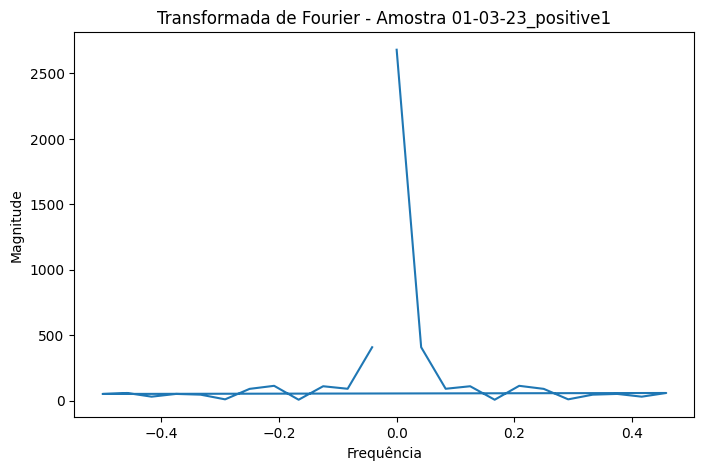

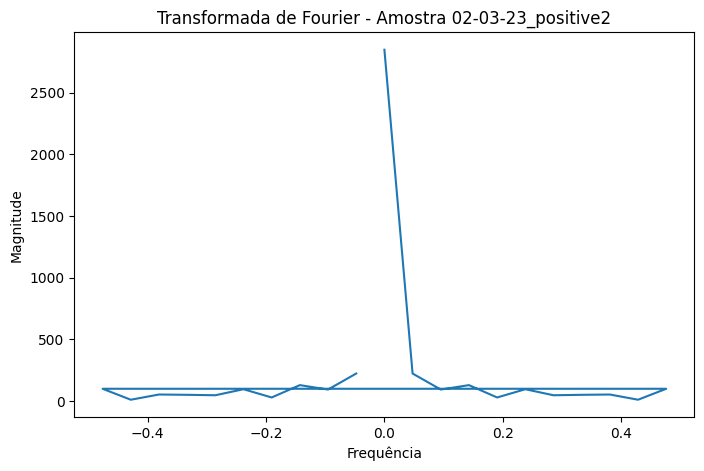

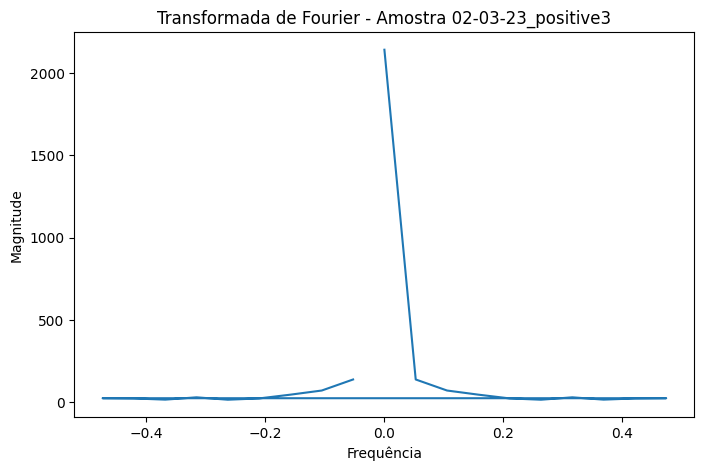

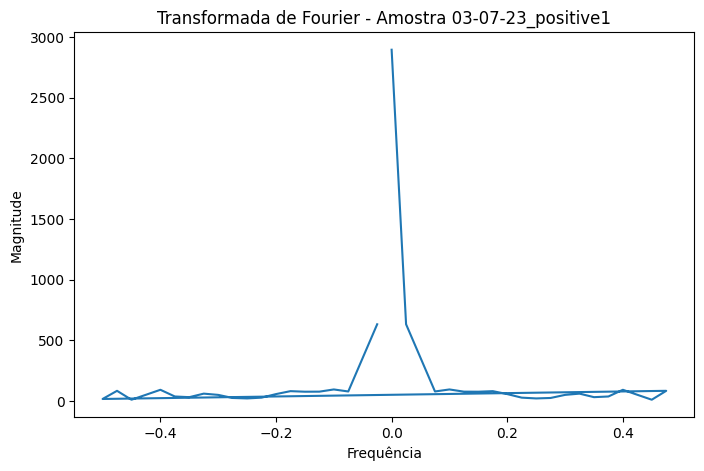

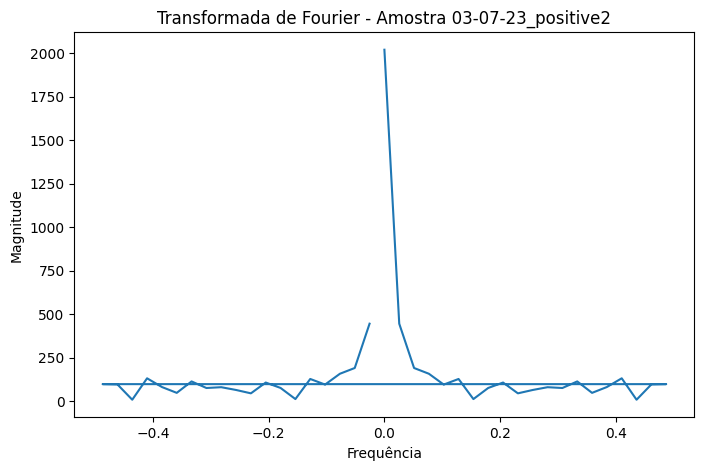

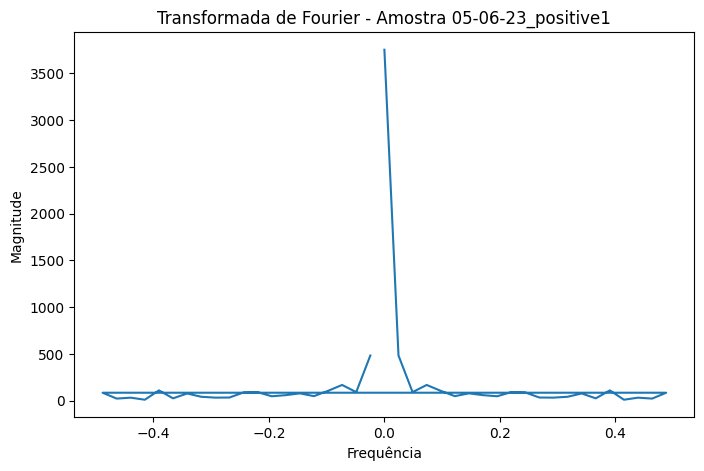

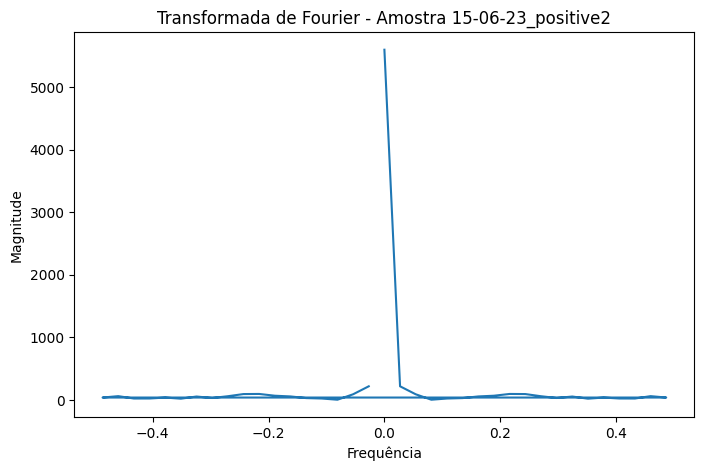

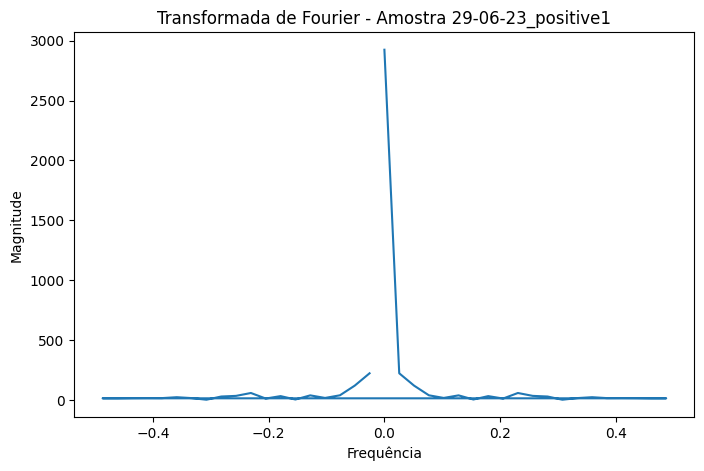

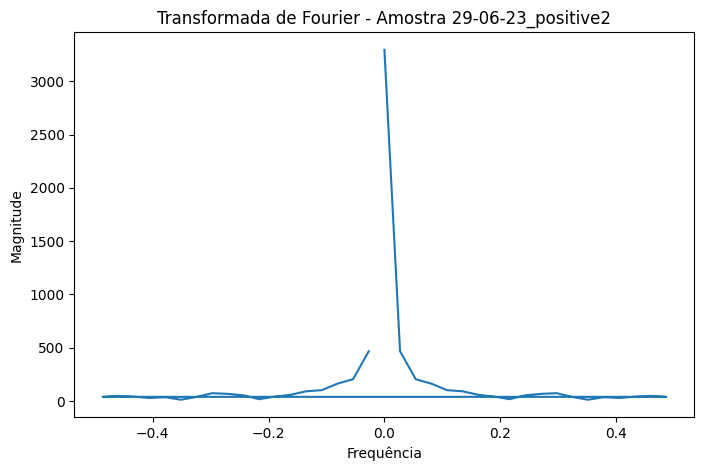

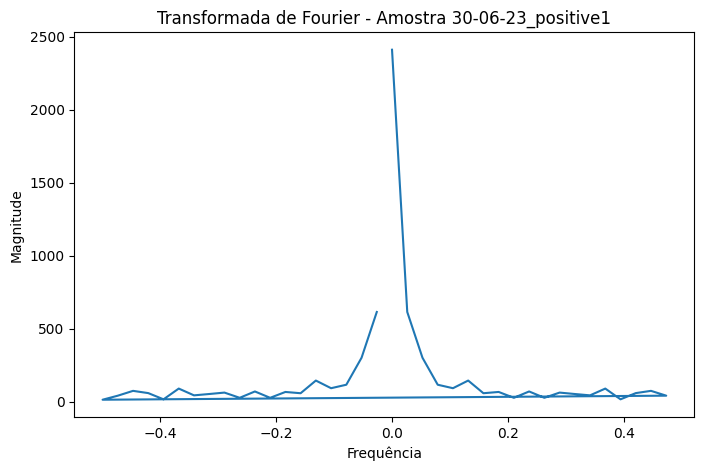

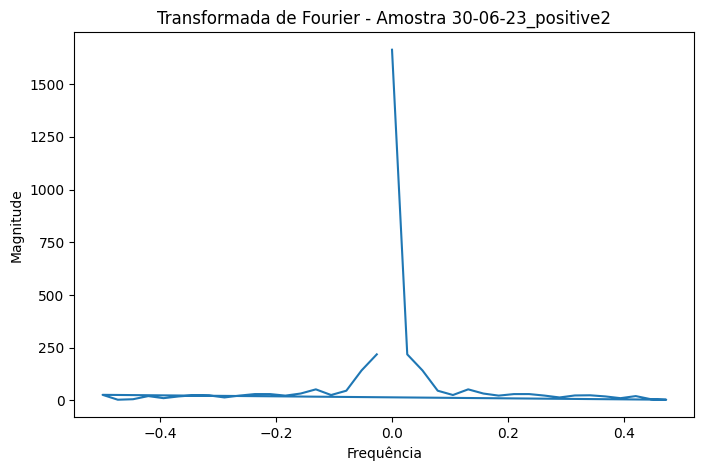

In [96]:
# Função para aplicar a transformada de Fourier
def plot_fourier_transform(sample_data):
    tempo = sample_data['Time_Sample']  # Variável x (tempo)
    brilho = sample_data['ValueV']  # Variável y (brilho)
    
    fourier_transform = np.fft.fft(brilho)  # Aplicar a transformada de Fourier
    freq = np.fft.fftfreq(len(tempo))  # Frequências correspondentes

    plt.figure(figsize = (8, 5))
    plt.plot(freq, np.abs(fourier_transform))  # Plotar a magnitude do espectro
    plt.title('Transformada de Fourier - Amostra {}'.format(sample_data['Chip'].iloc[0]))
    plt.xlabel('Frequência')
    plt.ylabel('Magnitude')
    plt.show()

# Agrupar os dados por amostra (Chip) e aplicar a transformada de Fourier para cada grupo
grupos_positive = df_positive.groupby('Chip')

for nome, grupo in grupos_positive:
    plot_fourier_transform(grupo)

#### Logaritmo Natural

In [82]:
df_ln_positive = df_positive.copy()
df_ln_positive = df_ln_positive.drop(['Name_of_sample', 'Datetime', 'Date', 'Time', 'Target'], axis=1)

In [83]:
# Selecionar todas as colunas exceto 'Time_Sample'
columns_ln_positive = df_ln_positive.columns.drop(['Chip','Time_Sample'])

# Aplicar logaritmo natural
df_ln_positive[columns_ln_positive] = df_ln_positive[columns_ln_positive].apply(lambda col: col.map(lambda x: np.log(x) if x > 0 else x))

In [86]:
# Plots das variáveis extraídas
def create_app_ln_positive():
    app = dash.Dash(__name__)

    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    app.layout = html.Div([
        dcc.Dropdown(
            id = 'ln-positive-dropdown',
            options = [{'label': variavel, 'value': variavel} for variavel in variaveis_positive],
            value = 'ValueH',
            style = {'width': '50%'}
        ),
        dcc.Graph(id = 'grafico-positive-ln'),
    ])

    @app.callback(
        Output('grafico-positive-ln', 'figure'),
        [Input('ln-positive-dropdown', 'value')]
    )
    def update_graph(selected_variavel_positive):
        fig = px.line(df_ln_positive, x = 'Time_Sample', y = selected_variavel_positivo, color = 'Chip', title = f'Logaritmo natural de {selected_variavel_positive} em função do tempo',
                      labels = {'Time_Sample': 'Tempo (min)', selected_variavel_positive: 'Valor'})

        fig.update_layout(legend_title='Chip')

        return fig

    return app

app_ln = create_app_ln()
app_ln.run_server(debug = True, port = 8052)

In [115]:
def plots_ln(df_ln_positive):
    current_directory = os.getcwd()
    
    # Criar o caminho completo para a pasta 'Gráficos'
    graphs_directory = os.path.join(current_directory, 'Gráficos')

    # Verificar se a pasta 'Gráficos' existe e criar se não existir
    if not os.path.exists(graphs_directory):
        os.makedirs(graphs_directory)
        
    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    for variavel in variaveis_positive:
        plt.figure(figsize = (8, 6))

        for chip in df_ln_positive['Chip'].unique():
            # Filtrar o DataFrame por chip e variável
            data = df_ln_positive[df_ln_positive['Chip'] == chip]

            plt.plot(data['Time_Sample'], data[variavel], label = chip)

        plt.xlabel('Frequência')
        plt.ylabel('Magnitude')
        plt.title(f'Logaritmo Natural de {variavel}')
        plt.legend(title = 'Chip', loc = 'center left', bbox_to_anchor = (1, 0.5))  # Posiciona a legenda fora do gráfico
        plt.grid(True)

        # Salvar o gráfico como imagem PNG
        plt.savefig(os.path.join(graphs_directory, f'Log_{variavel}.png'), bbox_inches = 'tight')  # Usado para ajustar o espaço para que a legenda não seja cortada

        # Fechar a figura para liberar memória
        plt.close()

# Chamar a função para gerar e salvar os gráficos
plots_ln(df_ln_positive)

#### Desvio Padrão

In [90]:
df_std_positive = df_positive.copy()
df_std_positive = df_std_positive.drop(['Name_of_sample', 'Datetime', 'Date', 'Time', 'Target'], axis=1)

In [120]:
def raw_plots_with_std(df_positive):
    current_directory = os.getcwd()
    graphs_directory = os.path.join(current_directory, 'Gráficos')

    if not os.path.exists(graphs_directory):
        os.makedirs(graphs_directory)

    variaveis_positive = ['ValueH', 'ValueS', 'ValueV', 'Total_area', 'Number_of_spots_cv2', 'Number_of_spots_LoG', 'Number_of_spots_DoG', 'Number_of_spots_DoH']

    for variavel in variaveis_positive:
        plt.figure(figsize = (8, 6))

        # Lista para armazenar desvio padrão de todos os Chips para uma variável
        std_list = []

        for chip in df_positive['Chip'].unique():
            data = df_positive[df_positive['Chip'] == chip]

            plt.plot(data['Time_Sample'], data[variavel], label=chip)

            # Calcular desvio padrão para cada Chip e variável
            std = data[variavel].std()
            std_list.append(std)

        # Calcular o desvio padrão geral considerando todos os Chips
        overall_std = np.mean(std_list)

        # Adicionar a linha do desvio padrão geral
        plt.axhline(y = overall_std, color = 'red', linestyle = '--', label = f'Desvio Padrão Geral: {overall_std:.2f}')

        plt.xlabel('Tempo (min)')
        plt.ylabel('Valor')
        plt.title(f'Variação de {variavel} ao decorrer do tempo com Desvio Padrão')
        plt.legend(title = 'Chip', loc = 'center left', bbox_to_anchor = (1, 0.5))
        plt.grid(True)

        plt.savefig(os.path.join(graphs_directory, f'Std_{variavel}_plot_with_std.png'), bbox_inches = 'tight')
        plt.close()

# Chamar a função para gerar e salvar os gráficos com linhas de desvio padrão
raw_plots_with_std(df_positive)

## RNA

In [43]:
df_rna = df_chip.copy()

In [44]:
df_rna = df_rna.drop(['Chip', 'Name_of_sample', 'Datetime', 'Date', 'Time', 'Time_Sample'], axis=1)

In [45]:
df_rna['Target'] = df_rna['Target'].map({'Positive': 1, 'Negative': 0})

In [46]:
df_rna.head()

,ValueH,ValueS,ValueV,Total_area,Number_of_spots_cv2,Number_of_spots_LoG,Number_of_spots_DoG,Number_of_spots_DoH,Target
0,129.171875,245.945849,77.367111,0.0,0,0,0,0,1
1,135.249566,246.915191,77.204861,0.0,0,0,0,0,1
2,134.105655,247.956194,90.288039,0.0,0,0,0,0,1
3,129.186734,247.872472,89.540058,0.0,0,0,0,0,1
4,120.984681,246.438879,81.754596,0.0,0,0,0,0,1


In [47]:
# Definição das variáveis
y = df_rna.Target
X = df_rna.drop('Target',axis=1)

In [48]:
# Divisão dos dados para treinamento e teste - função train_test_split(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
# Transformação dos dados de treinamento em arquivo
train_data = X_train.copy()
train_data['Target'] = y_train
train_data.to_excel("Train.xlsx")

In [50]:
# Transformação dos dados de teste em arquivo
test_data = X_test.copy()
test_data['Target'] = y_test
test_data.to_excel("Test.xlsx")

In [51]:
print(X_train.shape); print(X_test.shape)

(574, 8)
(144, 8)


### Análise através dos histogramas

<li>Um histograma simétrico (ou unimodal) centraliza os dados na média (medida central) e possui características por meio da distribuição da média e do desvio padrão.
<li>Um histograma é distorcido à direita quando a distribuição de dados indica a ocorrência de altos valores com baixa frequência.
<li>Um histograma é distorcido à esquerda quando a frequência dos dados está concentrado nos altos valores.

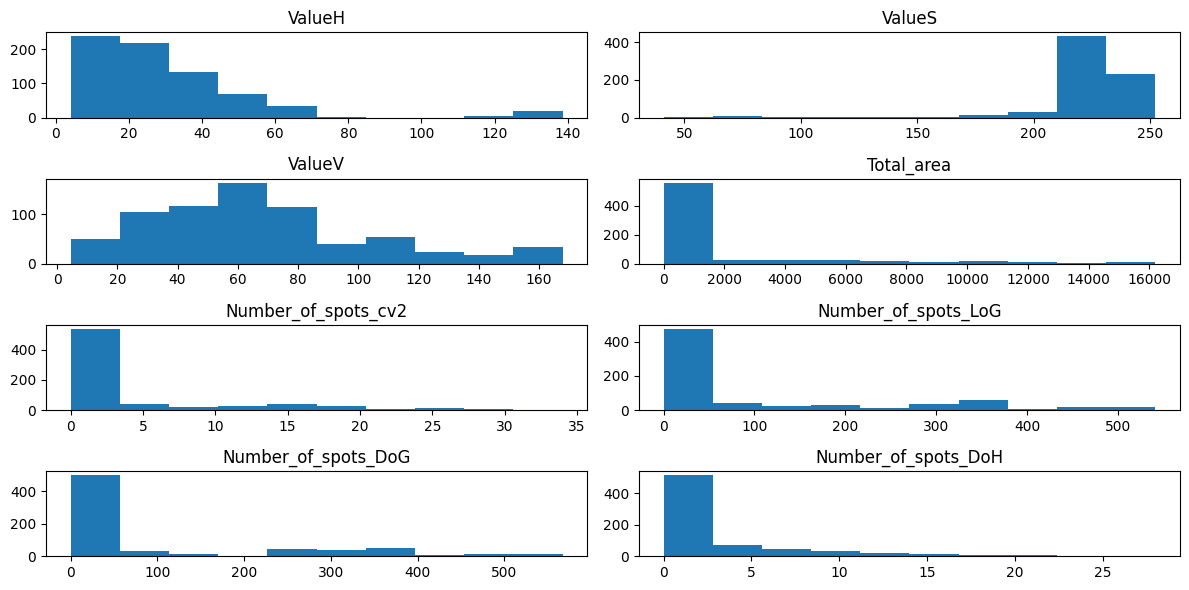

In [52]:
# Obtém o número de colunas no DataFrame
num_colunas = X.shape[1]

# Calcula o número de linhas e colunas para os subplots
num_linhas = (num_colunas // 2) + (num_colunas % 2)
num_cols = 2

# Cria uma figura com subplots
fig, axs = plt.subplots(num_linhas, num_cols, figsize=(12, 6))

# Itera pelas colunas e cria um histograma para cada uma
for i in range(num_colunas):
    row = i // num_cols
    col = i % num_cols
    
    axs[row, col].hist(X.iloc[:, i])
    axs[row, col].set_title(X.columns[i])
    
for i in range(num_colunas, num_linhas * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

## Modelo Multilayer Perceptron (MLP)

### #1
Se a saída for uma classificação binária, o número de nós na camada de saída será um.

### Classifier

In [53]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((574, 8), (574,), (144, 8), (144,))

In [54]:
scaler = StandardScaler()  

# Ajustar o scaler aos dados de treinamento
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  

# Aplicar a mesma transformação aos dados de teste
X_test = scaler.transform(X_test)

In [55]:
modelRNA_Classifier = MLPClassifier(activation = 'identity', alpha = 0.0001, hidden_layer_sizes = (100,), learning_rate = 'constant', solver = 'lbfgs', max_iter = 1400)

In [56]:
modelRNA_Classifier = modelRNA_Classifier.fit(X_train, y_train)

In [61]:
# Aplicação do modelo 
generated_model_Classifier = modelRNA_Classifier.fit(X_train, y_train)
print(generated_model_Classifier)

MLPClassifier(activation='identity', max_iter=1400, solver='lbfgs')


In [62]:
# Teste para plotar a rede neural
# Obtenção dos pesos e vieses da rede neural
weights = generated_model_Classifier.coefs_
biases = generated_model_Classifier.intercepts_

# Configuração do grafo
graph = Digraph()

# Adiciona nós para a camada de entrada
for i in range(X.shape[1]):
    graph.node('Input{}'.format(i+1), label='Input{}'.format(i+1))

# Adiciona nós para a camada oculta
for i in range(weights[0].shape[1]):
    graph.node('Hidden{}'.format(i+1), label='Hidden{}'.format(i+1))

# Adiciona nós para a camada de saída
for i in range(weights[1].shape[1]):
    graph.node('Output{}'.format(i+1), label='Output{}'.format(i+1))

# Adiciona conexões entre os nós
for i in range(X.shape[1]):
    for j in range(weights[0].shape[1]):
        graph.edge('Input{}'.format(i+1), 'Hidden{}'.format(j+1), label='W={:.2f}'.format(weights[0][i][j]))

for i in range(weights[0].shape[1]):
    for j in range(weights[1].shape[1]):
        graph.edge('Hidden{}'.format(i+1), 'Output{}'.format(j+1), label='W={:.2f}'.format(weights[1][i][j]))

# Salvar o grafo como um arquivo DOT
graph.render('neural_network', format='png', cleanup=True)

# Exibir o grafo
graph.view()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.433989 to fit


'neural_network.pdf'

In [63]:
# Previsão para amostras de treinamento
y_train_predict_Classifier = modelRNA_Classifier.predict(X_train)

In [64]:
# Previsão para amostras de teste
y_test_predict_Classifier = modelRNA_Classifier.predict(X_test)

In [67]:
# Comparação do y real com os previstos pelo modelo - treinamento 
comparation_train_Classifier = pd.DataFrame()
comparation_train_Classifier['Real'] = y_train
comparation_train_Classifier['Predito'] = y_train_predict_Classifier

In [68]:
comparation_train_Classifier.reset_index(inplace=True, drop=True)
comparation_train_Classifier

,Real,Predito
0,1,1
1,0,0
2,1,1
3,1,1
4,1,1
...,...,...
569,0,0
570,0,0
571,0,1
572,1,1


In [69]:
# Comparação do y real com os previstos pelo modelo - teste
comparation_test_Classifier = pd.DataFrame()
comparation_test_Classifier['Real'] = y_test
comparation_test_Classifier['Predito'] = y_test_predict_Classifier

In [70]:
comparation_test_Classifier.reset_index(inplace=True, drop=True)
comparation_test_Classifier

,Real,Predito
0,1,0
1,0,0
2,0,0
3,1,1
4,1,0
...,...,...
139,0,0
140,1,1
141,0,0
142,0,1


In [73]:
# Acurácia do modelo
train_accuracy_Classifier = accuracy_score(y_train, y_train_predict_Classifier)
test_accuracy_Classifier = accuracy_score(y_test, y_test_predict_Classifier)
#validation_accuracy = accuracy_score(y_validation, y_validation_predict)

In [74]:
# Matriz de confusão do modelo
confusion_matrix_train_Classifier = confusion_matrix(y_train, y_train_predict_Classifier)
confusion_matrix_test_Classifier = confusion_matrix(y_test, y_test_predict_Classifier)
#confusion_matrix_validation = confusion_matrix(y_validation, y_validation_predict)

In [75]:
confusion_matrix_train_Classifier

array([[246,  37],
       [ 59, 232]], dtype=int64)

In [76]:
confusion_matrix_train_Classifier

array([[246,  37],
       [ 59, 232]], dtype=int64)

In [77]:
# Recall do modelo
recall_train_Classifier = recall_score(y_train, y_train_predict_Classifier)
recall_test_Classifier = recall_score(y_test, y_test_predict_Classifier)
#recall_validation = recall_score(y_validation, y_validation_predict)

In [78]:
# Precisão do modelo
precision_train_Classifier = precision_score(y_train, y_train_predict_Classifier)
precision_test_Classifier = precision_score(y_test, y_test_predict_Classifier)
#precision_validation = precision_score(y_validation, y_validation_predict)

In [79]:
# ROC do modelo
ROC_train_Classifier = roc_auc_score(y_train, y_train_predict_Classifier)
ROC_test_Classifier = roc_auc_score(y_test, y_test_predict_Classifier)
#ROC_validation = roc_auc_score(y_validation, y_validation_predict)

In [80]:
# F1 do modelo
F1_train_Classifier = f1_score(y_train, y_train_predict_Classifier)
F1_test_Classifier = f1_score(y_test, y_test_predict_Classifier)
#F1_validation = f1_score(y_validation, y_validation_predict)

In [81]:
# Perda do modelo
loss_train_Classifier = brier_score_loss(y_train, y_train_predict_Classifier)
loss_test_Classifier = brier_score_loss(y_test, y_test_predict_Classifier)
#loss_validation = brier_score_loss(y_validation, y_validation_predict)

In [82]:
# Parâmetros concatenados do modelo
parameters_training_Classifier = pd.DataFrame({'Parameter': 'Training', 'Accuracy': train_accuracy_Classifier, 'Precision': precision_train_Classifier, 'ROC': ROC_train_Classifier, 'Seletive': recall_train_Classifier, 'Loss': loss_train_Classifier}, index=[0])
parameters_test_Classifier = pd.DataFrame({'Parameter': 'Test', 'Accuracy': test_accuracy_Classifier, 'Precision': precision_test_Classifier, 'ROC': ROC_test_Classifier, 'Seletive': recall_test_Classifier, 'Loss': loss_test_Classifier}, index=[0])
#parameters_validation = pd.DataFrame({'Parameter': 'Validation', 'Accuracy': validation_accuracy, 'Precision': precision_validation, 'ROC': ROC_validation, 'Seletive': recall_validation, 'Loss': loss_validation}, index=[0])

In [83]:
# Transformação dos dados do modelo em arquivo
parametersdata_Classifier = pd.concat([parameters_training_Classifier, parameters_test_Classifier])

In [84]:
parametersdata_Classifier

,Parameter,Accuracy,Precision,ROC,Seletive,Loss
0,Training,0.832753,0.862454,0.833254,0.797251,0.167247
0,Test,0.812500,0.876712,0.817663,0.780488,0.187500


In [86]:
parametersdata_Classifier.to_excel('Parameters_of_RNA_Classification_Classifier.xlsx', index= False)

### Otimização dos parâmetros

In [ ]:
param_grid = [
    {
        'hidden_layer_sizes': [(100,), (110,)],
        'activation' : ['identity', 'tanh', 'relu'],
        'solver' : ['lbfgs', 'sgd'],
        'alpha' : [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
        'max_iter': [2000, 3000, 4000, 5000, 6000]
    }
]

In [ ]:
grid = GridSearchCV(modelRNA, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X,y)

print("Best parameters set found on development set:")
print(grid.best_params_)

In [ ]:
pd.DataFrame(grid.cv_results_)

### #2

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(90,), activation='identity', solver='lbfgs', alpha=0.0001, learning_rate='adaptive', max_iter=900)
mlp.fit(X_train2,y_train2)
predict_train = mlp.predict(X_train2)
predict_test = mlp.predict(X_test2)

In [ ]:
print(confusion_matrix(y_train2, predict_train))
print(classification_report(y_train2, predict_train))

In [ ]:
comp_train = pd.DataFrame()
comp_train['Treinamento'] = y_train2
comp_train['Predito'] = predict_train

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(comp_train)

In [ ]:
print(confusion_matrix(y_test2, predict_test))
print(classification_report(y_test2, predict_test))

In [ ]:
comp_test = pd.DataFrame()
comp_test['Treinamento'] = y_test2
comp_test['Predito'] = predict_test

In [ ]:
comp_test

## Teste

In [ ]:
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
Xtrain = scaler.transform(X_train)
Xtest = scaler.transform(X_test)

In [ ]:
MLP = Sequential()
MLP.add(InputLayer(input_shape=(9, ))) # input layer
MLP.add(Dense(256, activation='relu')) # hidden layer 1
MLP.add(Dense(256, activation='relu')) # hidden layer 2
MLP.add(Dense(10, activation='softmax')) # output layer

# summary
MLP.summary()

In [ ]:
MLP.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [ ]:
model.fit(Xtrain, y_train, epochs=20, batch_size=128)

In [ ]:
y_pred = model.predict(Xtest)
score = model.evaluate(Xtest, y_test,verbose=1)
print(score)

## Amostras antigas

In [ ]:
os.chdir(r'C:\Users\btieppo\Processing\BBD_Dataframe_vs2-nt')

In [ ]:
df_old_samples = pd.read_excel("DataVal4.xlsx")

In [ ]:
df_old_samples.head()

In [ ]:
df_old_samples['Target'] = df_old_samples['Target'].map({'Positive': 1, 'Negative': 0})

In [ ]:
df_old_samples = df_old_samples.drop(['Chip', 'Name_of_sample', 'Datetime'], axis=1)

In [ ]:
X_old_samples = df_old_samples.drop('Target',axis=1)
y_old_samples = df_old_samples['Target']

In [ ]:
# Previsão para amostras de validação
y_old_samples_predict = modelRNA.predict(X_old_samples)

In [ ]:
# Comparação do y real com os previstos pelo modelo - validação
comparation_old_samples = pd.DataFrame()
comparation_old_samples['Real'] = y_old_samples
comparation_old_samples['Predito'] = y_old_samples_predict

In [ ]:
comparation_old_samples.reset_index(inplace=True, drop=True)
comparation_old_samples

In [ ]:
# Acurácia do modelo
accuracy_old_samples = accuracy_score(y_old_samples, y_old_samples_predict)

In [ ]:
# Matriz de confusão do modelo
confusion_matrix_old_samples = confusion_matrix(y_old_samples, y_old_samples_predict)

In [ ]:
# Recall do modelo
recall_old_samples = recall_score(y_old_samples, y_old_samples_predict)

In [ ]:
# Precisão do modelo
precision_old_samples = precision_score(y_old_samples, y_old_samples_predict)

In [ ]:
# ROC do modelo
ROC_old_samples = roc_auc_score(y_old_samples, y_old_samples_predict)

In [ ]:
# F1 do modelo
F1_old_samples = f1_score(y_old_samples, y_old_samples_predict)

In [ ]:
# Perda do modelo
loss_old_samples = brier_score_loss(y_old_samples, y_old_samples_predict)

In [ ]:
# Parâmetros concatenados do modelo
parameters_old_samples = pd.DataFrame({'Parameter': 'Old Samples', 'Accuracy': accuracy_old_samples, 'Precision': precision_old_samples, 'ROC': ROC_old_samples, 'Seletive': recall_old_samples, 'Loss': loss_old_samples}, index=[0])

In [ ]:
# Transformação dos dados do modelo em arquivo
parameters_old_samples = pd.concat([parameters_old_samples])

In [ ]:
parameters_old_samples